In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [52]:
sns.set(style='white')

## Performance vs. PeptideLocator figures

In [53]:
df_metrics = pd.read_csv('../evaluation/crf_model_all_cv_esm2_l33_balancedsplit.csv', index_col=[0,1])
means = df_metrics.groupby(level=0).mean()
stds = df_metrics.groupby(level=0).std()

In [54]:
df_peptidelocator = pd.read_csv('../evaluation/peptidelocator.csv', index_col=0)
df_peptidelocator

,precision peptides,recall peptides,f1 peptides,precision all,recall all,f1 all
0,0.021304,0.094057,0.034740,0.023092,0.043263,0.030112
1,0.036350,0.159600,0.059213,0.041689,0.077811,0.054291
2,0.044235,0.193483,0.072007,0.052572,0.097754,0.068373
3,0.050910,0.221626,0.082800,0.062614,0.115892,0.081302


In [56]:
# prepare example peptide
import pickle
# test_probs, test_preds, test_labels, test_names= pickle.load(open('../hyperparam_runs_overlap_fixed/1/7/4/test_outputs.pickle', 'rb'))
test_probs, test_preds, test_labels, test_names= pickle.load(open('../hyperparam_runs_esm2_650_balanced_33/1/7/3/test_outputs.pickle', 'rb'))
test_probs = [x for sublist in test_probs for x in sublist] # remove batches, one list item per protein.

df = pd.read_csv('../data/uniprot_12052022_cv_5_50/labeled_sequences.csv', index_col='protein_id')
df_partitions = pd.read_csv('../data/uniprot_12052022_cv_5_50/graphpart_assignments.csv', index_col='AC')
df = df.join(df_partitions)
df_test = df.loc[df['cluster'] ==1]

name = 'P01275'
idx = np.where(np.array(test_names) == name)[0].item()

protein = df.loc[name]['sequence']

In [57]:

from typing import List, Tuple
import matplotlib.patches as patches

def simplify_probs(probs):
    probs_simple = probs[:,:3].copy()
    probs_simple[:,1] =  probs[:,1:51].sum(axis=1)
    probs_simple[:,2] =  probs[:,51:].sum(axis=1)

    return probs_simple

def simplify_preds(preds):

    def simplify_fn(x):
        if x>0:
            if x>50:
                return 2
            else:
                return 1
        else:
            return 0 
    preds_simple = [simplify_fn(x) for x in preds]
    return preds_simple

def parse_coordinate_string(string, deduplicate=True, sep=',') -> Tuple[List[int], List[int]]:
    coords = [tuple(x.rstrip(')').lstrip('(').split('-')) for x in string.split(sep)]
    if deduplicate:
        coords = list(set(coords))
    x, y = zip(*coords)
    x = [int(p) for p in x]
    y = [int(p) for p in y]

    return x, y

In [58]:
def plot_peptides(
    protein_sequence: str, 
    peptide_starts: List[int], 
    peptide_ends: List[int], 
    protein_name: str = None,
    thickness: int = 5,
    spacing: int = 1,
    peptide_color = 'grey',
    backbone_color = 'darkblue',
    names = None,
    max_overlapping_peptides: int = 10,
    figsize: Tuple[float, float] = (12,4.5),
    is_uniprot_indexed: bool = True,
    ax = None,
    ):

    if is_uniprot_indexed:
        peptide_starts = [x-1 for x in peptide_starts]
        peptide_ends = [x-1 for x in peptide_ends]

    if len(peptide_starts) != len(peptide_ends):
        raise ValueError(f'peptide_starts and peptide_ends need to have same length! Got {len(peptide_starts)} and {len(peptide_ends)}')

    if names is None:
        names = [''] * len(peptide_starts)

    # long to short, then start to end.
    sort_fn = lambda x: (-(x[1]-x[0]), x[0])

    if type(peptide_color) == list:
        peptide_starts, peptide_ends, peptide_color, names = zip(*sorted(zip(peptide_starts,peptide_ends, peptide_color, names), key = sort_fn))
        peptide_color = list(peptide_color)
    else:
        peptide_starts, peptide_ends, names = zip(*sorted(zip(peptide_starts,peptide_ends, names), key = sort_fn))
    length = len(protein_sequence)


    peptides_plotted_at_position = np.zeros(length) # keep track how many peptides we already have at a position to compute y-offset.


    # set up the coordinate system
    min_x =  length - 10
    max_x = length + 10
    min_y = 0
    max_y = thickness+spacing * max_overlapping_peptides

    if ax is None:
        fig, ax  = plt.subplots(1,1,figsize=figsize)

    # plot the backbone.
    p = patches.FancyBboxPatch((0,0), length, thickness, fill=True, color=backbone_color, aa=True, boxstyle='round')
    ax.add_patch(p)
    ax.text(0,thickness*0.5, protein_name, color='black',verticalalignment='center')

    # plot the peptides.
    have_warned = False
    for idx, (start, end) in enumerate(zip(peptide_starts,peptide_ends)):

        color = peptide_color[idx] if type(peptide_color) == list else peptide_color

        if peptides_plotted_at_position[start:end+1].max() > max_overlapping_peptides:
            if not have_warned:
                print(f'Skipping {start}:{end}. Either increase max_overlapping_peptides or filter inputs.')
                have_warned = True
            continue
        # compute the y axis offset.
        y_offset = thickness + spacing  + peptides_plotted_at_position[start:end+1].max() * ( thickness + spacing)

        p = patches.FancyBboxPatch((start,y_offset), end-start, thickness, fill=True, facecolor=color, linewidth=2, edgecolor='white', boxstyle='round')

        #print(start, end, )
        ax.add_patch(p)
        ax.text(start,y_offset + thickness *0.5, names[idx], color='white', weight = 'bold',verticalalignment='center')

        # update the counts
        peptides_plotted_at_position[start:end+1] +=1
        


    ax.set_xlim(-5, length+5)
    ax.set_ylim(-1, (peptides_plotted_at_position.max() + 2) * (thickness + spacing))

    ax.set_yticks([])
    ax.invert_yaxis()

    return ax

In [60]:
cmap = matplotlib.colors.ListedColormap(['#CCC5BD', '#001965', '#2A918B'], name='from_list', N=None)
cmap = matplotlib.colors.ListedColormap(['#DFDBDB',  '#048BA8', '#E8AE68', '#808080'], name='from_list', N=None)

legend_size = 14


fig = plt.figure(figsize=(17.5,8))
axs = matplotlib.gridspec.GridSpec(
                nrows=22,
                ncols=2,
                width_ratios=[0.6,2],
                height_ratios=None,#[2,2,0.5,0.5 ,2,2,2,1],
                wspace=0.3,
                hspace=0,
                #height_ratios=[3,0.5,1],
            )

ax = fig.add_subplot(axs[0:10,0])

width = 0.35
xpos = np.array([0,1,2,3] )
bars1 = ax.bar(xpos- width/2,means['precision all'], width, label='DeepPeptide', color=cmap.colors[1])
bars2 = ax.bar(xpos + width/2,df_peptidelocator['precision peptides'], width, label='PeptideLocator', color=cmap.colors[3])
ax.errorbar(xpos- width/2,means['precision all'], yerr=stds['precision all'], fmt='none', barsabove=True, ecolor='black', capsize=3)
ax.tick_params(axis='y', labelsize=legend_size)

ax.set_ylabel('Precision', fontsize=legend_size)
ax.set_xticks([0,1,2,3], ['±0', '±1', '±2', '±3'], fontsize=legend_size)
ax.legend(loc='upper left', fontsize=legend_size-1)
#ax.set_xticklabels('')
sns.despine(ax=ax)

ax.text(-0.3, 0.95, 'a', transform=ax.transAxes, 
            size=20, weight='bold')

ax = fig.add_subplot(axs[12:,0], sharey=ax)
bars1 = ax.bar(xpos- width/2,means['recall all'], width, label='DeepPeptide', color=cmap.colors[1])
bars2 = ax.bar(xpos + width/2,df_peptidelocator['recall peptides'], width, label='PeptideLocator', color=cmap.colors[3])
ax.errorbar(xpos- width/2,means['recall all'], yerr=stds['recall all'], fmt='none', barsabove=True, ecolor='black', capsize=3)
ax.tick_params(axis='y', labelsize=legend_size)
ax.set_ylabel('Recall', fontsize=legend_size)
sns.despine(ax=ax)

ax.set_xticks([0,1,2,3], ['±0', '±1', '±2', '±3'], fontsize=legend_size)
ax.set_ylim(0,1)
# ax.legend(loc='upper left', fontsize=legend_)
ax.set_xlabel('Tolerance window around\ntrue start/end position [Amino acids]', fontsize=legend_size)

ax.text(-0.3, 0.95, 'b', transform=ax.transAxes, 
            size=20, weight='bold')




### Peptides
ax = fig.add_subplot(axs[0:5,1])
x, y =  parse_coordinate_string(df_test.loc[name]['coordinates'])
x_pro, y_pro =  parse_coordinate_string(df_test.loc[name]['propeptide_coordinates'])
colors = [cmap.colors[1]] * len(x) + [cmap.colors[2]] * len(x_pro)
x, y = x+x_pro, y+y_pro

# order of this not fixed when not sorted.
x, y, colors = zip(*sorted(zip(x,y, colors)))
colors = list(colors) # my API wants list.

names = ['GRPP', 'Glucagon', 'Oxyntomodulin', '', 'GLP-1', 'GLP-1', 'GLP-1', '', 'GLP-2']
plot_peptides(protein, x, y, 'Preproglucagon', peptide_color=colors, backbone_color=cmap.colors[0], names=names, max_overlapping_peptides=40, ax=ax)
sns.despine(ax=ax,left=True, bottom=True, )
#ax.get_xaxis().set_visible(False)
#ax.set_xlabel('Sequence position')
#ax.xaxis.grid()
ax.tick_params(axis='x', bottom=False, labelbottom=False)

ax.set_ylabel('True peptides\n(UniProt)',labelpad=15, fontsize=legend_size)

ax.text(-0.12, 0.95, 'c', transform=ax.transAxes, 
            size=20, weight='bold')

# make peptide plot a bit larger
# print(ax.get_ylim()) # (30.0, -1.0)
ax.set_ylim(23.5,-1)

def make_gridlines(x,y,ax):
    for x_i in x:
        ax.axvline(x_i-1, c='lightgrey', zorder=-100, linewidth=1)
    for y_i in y:
        ax.axvline(y_i-1, c='lightgrey', zorder=-100, linewidth=1)
make_gridlines(x,y, ax)

### Line plots

ax = fig.add_subplot(axs[5:11,1], sharex=ax)
#cmap = plt.get_cmap('tab10')
#cmap = matplotlib.colors.ListedColormap(['#CCC5BD', '#001965', '#2A918B'], name='from_list', N=None)
#cmap.colors[0] = '#001965'

protein  = df_test.loc[name]['sequence']
probs = simplify_probs(test_probs[idx])#np_sigmoid(test_logits[idx][:len(protein)])
#ax.plot(probs[:,0][:len(protein)], fillstyle='full', label='None', linestyle='--', linewidth=0.5, c=cmap.colors[0])
ax.plot(probs[:,1][:len(protein)], fillstyle='full', label='Peptide', c=cmap.colors[1])
ax.plot(probs[:,2][:len(protein)], fillstyle='full', label='Propeptide', c=cmap.colors[2])

ax.set_ylim(-0.01,1.05)
ax.axhline(0.5, linestyle='--', c='red', xmin=0, xmax=1, linewidth=1)
ax.legend(loc='upper left', fontsize=legend_size)
ax.set_ylabel('Probability', fontsize=legend_size)
ax.tick_params(axis='y', labelsize=legend_size)
sns.despine(ax=ax, bottom=False)
ax.yaxis.grid(False)
#ax.get_xaxis().set_visible(False)
#ax.xaxis.grid()
make_gridlines(x,y, ax)
#ax.set_xticklabels('')
ax.tick_params(axis='x', bottom=False, labelbottom=False)

ax.text(-0.12, 0.9, 'd', transform=ax.transAxes, 
            size=20, weight='bold')



ax = fig.add_subplot(axs[12,1], sharex=ax)

norm = matplotlib.colors.BoundaryNorm([0,1,2],2)
ax.imshow(np.array(simplify_preds(test_preds[idx][:len(protein)]))[None,:].repeat(5,axis=0), cmap=cmap, norm=norm, zorder=100)
ax.grid(False)
ax.set_xlabel('')
ax.tick_params(axis='y', left=False, labelleft=False)
#ax.get_xaxis().set_visible(False)
ax.xaxis.grid(zorder=-100)
# ax.tick_params(axis='x', bottom=False)
sns.despine(ax=ax,left=True, bottom=True)
ax.tick_params(axis='x', bottom=False, labelbottom=False)
ax.set_ylabel('Prediction', rotation='horizontal', ha='right', va='center',labelpad=-12, fontsize=legend_size)


# Fill in gridlines in gaps around imshow
ax = fig.add_subplot(axs[11,1], sharex=ax)
make_gridlines(x,y, ax)
sns.despine(ax=ax,left=True, bottom=True, top=False)
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(axis='x', bottom=False, labelbottom=False, top=False, labeltop=False)
ax.tick_params(axis='y', left=False, labelleft=False)
ax = fig.add_subplot(axs[13:14,1], sharex=ax)
make_gridlines(x,y, ax)
sns.despine(ax=ax,left=True, bottom=True)
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(axis='x', bottom=False, labelbottom=False)
ax.tick_params(axis='y', left=False, labelleft=False, labelsize=legend_size)

ax = fig.add_subplot(axs[14:20,1], sharex=ax)
peptidelocator = open('../results/peptide_locator/any/P01275.fasta.PeptideLocator', 'r').read()
peptidelocator = np.array([float(x) for x in peptidelocator.split(' ')])
ax.plot(peptidelocator, fillstyle='full', label='PeptideLocator', c=cmap.colors[3])
ax.axhline(0.5, linestyle='--', c='red', xmin=0, xmax=1, linewidth=1)
ax.set_ylim(-0.01,1.05)
ax.tick_params(axis='y', labelsize=legend_size)
ax.legend(loc='upper left', fontsize=legend_size)
ax.set_ylabel('Probability', fontsize=legend_size)
#ax.xaxis.grid()

ax.text(-0.12, 1, 'e', transform=ax.transAxes, 
            size=20, weight='bold')

make_gridlines(x,y, ax)
sns.despine(ax=ax)

ax.tick_params(axis='x', bottom=False, labelbottom=False)

ax = fig.add_subplot(axs[20,1], sharex=ax)
make_gridlines(x,y, ax)
sns.despine(ax=ax,left=True, bottom=True, top=False)
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(axis='x', bottom=False, labelbottom=False, top=False, labeltop=False)
ax.tick_params(axis='y', left=False, labelleft=False, labelsize=legend_size)

ax = fig.add_subplot(axs[21:,1], sharex=ax)

norm = matplotlib.colors.BoundaryNorm([0,0.1,0.2],3) # hacky norm to map 1 to color 3
ax.imshow(1*(peptidelocator>0.5)[None,:].repeat(5,axis=0), cmap=cmap, norm=norm, zorder=100)
ax.grid(False)
ax.set_xlabel('')
ax.tick_params(axis='y', left=False, labelleft=False)
#ax.get_xaxis().set_visible(False)
ax.xaxis.grid(zorder=-100)
# ax.tick_params(axis='x', bottom=False)
sns.despine(ax=ax,left=True, bottom=False)
# ax.tick_params(axis='x', bottom=False, labelbottom=False)
ax.set_ylabel('Prediction', rotation='horizontal', ha='right', va='center',labelpad=-12, fontsize=legend_size)

ax.set_xlabel('Sequence position', fontsize=legend_size)
ax.tick_params(axis='x', labelsize=legend_size)
ax.tick_params(axis='y', labelsize=legend_size)
make_gridlines(x,y, ax)

plt.savefig('../figures/figure_2.png', dpi=1200,bbox_inches='tight')
plt.savefig('../figures/figure_2.svg',bbox_inches='tight')

## Detailed performance for all windows

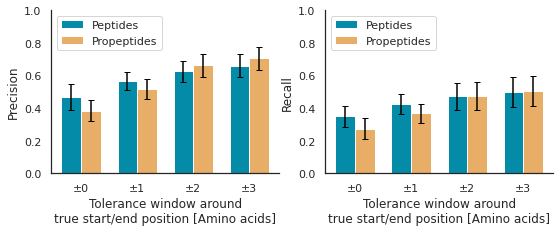

In [35]:
fig, axs = plt.subplots(1,2, figsize=(9,3))
ax = axs[0]
width = 0.35
xpos = np.array([0,1,2,3] )
bars1 = ax.bar(xpos- width/2,means['precision peptides'], width, label='Peptides', color=cmap.colors[1])
bars2 = ax.bar(xpos + width/2,means['precision propeptides'], width, label='Propeptides', color=cmap.colors[2])
ax.errorbar(xpos- width/2,means['precision peptides'], yerr=stds['precision peptides'], fmt='none', barsabove=True, ecolor='black', capsize=3)
ax.errorbar(xpos+ width/2,means['precision propeptides'], yerr=stds['precision propeptides'], fmt='none', barsabove=True, ecolor='black', capsize=3)

ax.set_ylabel('Precision')
ax.set_xticks([0,1,2,3], ['±0', '±1', '±2', '±3'])
ax.legend(loc='upper left')
ax.set_xlabel('Tolerance window around\ntrue start/end position [Amino acids]')
ax.set_ylim(0,1)
sns.despine(ax=ax)

ax = axs[1]
bars1 = ax.bar(xpos- width/2,means['recall peptides'], width, label='Peptides', color=cmap.colors[1])
bars2 = ax.bar(xpos + width/2,means['recall propeptides'], width, label='Propeptides', color=cmap.colors[2])
ax.errorbar(xpos- width/2,means['recall peptides'], yerr=stds['recall peptides'], fmt='none', barsabove=True, ecolor='black', capsize=3)
ax.errorbar(xpos+ width/2,means['recall propeptides'], yerr=stds['recall propeptides'], fmt='none', barsabove=True, ecolor='black', capsize=3)

ax.set_ylabel('Recall')
ax.set_xlabel('Tolerance window around\ntrue start/end position [Amino acids]')
ax.set_xticks([0,1,2,3], ['±0', '±1', '±2', '±3'])
ax.legend(loc='upper left')
ax.set_ylim(0,1)
sns.despine(ax=ax)


plt.savefig('../figures/performance_peptide_propeptide.png', dpi=1200,bbox_inches='tight')
plt.savefig('../figures/performance_peptide_propeptide.svg',bbox_inches='tight')



In [36]:
from scipy.stats import ttest_rel

x = df_metrics.loc[0]['precision peptides']
y = df_metrics.loc[0]['precision propeptides']

ttest_rel(x,y)

Ttest_relResult(statistic=4.613703076117549, pvalue=0.00018949525946378805)

In [37]:
x = df_metrics.loc[1]['precision peptides']
y = df_metrics.loc[1]['precision propeptides']

ttest_rel(x,y)

Ttest_relResult(statistic=3.63820619038351, pvalue=0.001749496270015335)

In [38]:
x = df_metrics.loc[0]['recall peptides']
y = df_metrics.loc[0]['recall propeptides']

ttest_rel(x,y)

Ttest_relResult(statistic=4.609264592994729, pvalue=0.00019140792595164307)

In [39]:
x = df_metrics.loc[1]['recall peptides']
y = df_metrics.loc[1]['recall propeptides']

ttest_rel(x,y)

Ttest_relResult(statistic=4.269419248143755, pvalue=0.0004142633738183302)

## ESM2-650m vs ESM1b

In [45]:
df_metrics = pd.read_csv('../evaluation/lm_selection/crf_model_all_cv_balancedsplit.csv')

df_metrics['model'] = df_metrics['model'].str.split('/', expand=True)[1]
df_metrics = df_metrics.set_index(['tolerance', 'model'])

means = df_metrics.groupby(level=[0,1]).mean()
stds = df_metrics.groupby(level=[0,1]).std()

means = means.reorder_levels([1,0])
stds = stds.reorder_levels([1,0])

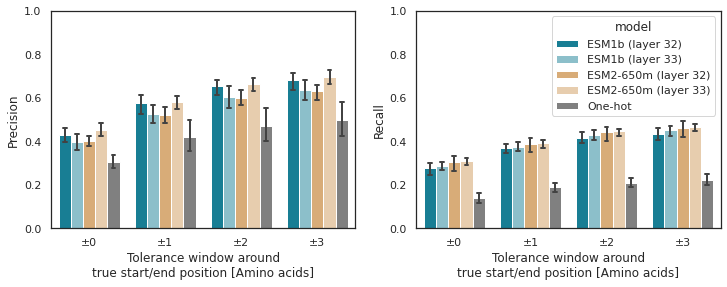

In [50]:
df_plot = df_metrics.reset_index()
df_plot['model'] = df_plot['model'].replace({
    'hyperparam_runs_esm1b_balanced': 'ESM1b (layer 32)', 
    'hyperparam_runs_esm1b_balanced_33': 'ESM1b (layer 33)',
    'hyperparam_runs_esm2_650_balanced_32': 'ESM2-650m (layer 32)',
    'hyperparam_runs_esm2_650_balanced_33': 'ESM2-650m (layer 33)',
    'hyperparam_runs_onehot': 'One-hot'
    })

# colors = ['#048BA8', '#E8AE68',  '#D1495B', '#13315C', '#DFDBDB',  '#808080']
colors = ['#048BA8', '#82c5d4', '#E8AE68',  '#f1cea4', '#808080']

fig, axs = plt.subplots(1,2, figsize=(12,4), sharey=False)

ax = axs[0]

sns.barplot(data=df_plot, y='precision all', x='tolerance', hue='model', ax=ax, palette=colors, capsize=0.05, errwidth=2)

ax.set_ylabel('Precision')
ax.set_xticks([0,1,2,3], ['±0', '±1', '±2', '±3'])
ax.set_xlabel('Tolerance window around\ntrue start/end position [Amino acids]')

ax.legend([],[], frameon=False)
ax.set_ylim(0,1)

ax = axs[1]
sns.barplot(data=df_plot, y='recall all', x='tolerance', hue='model', ax=ax, palette=colors, capsize=0.05, errwidth=2)

ax.set_ylabel('Recall')
ax.set_xticks([0,1,2,3], ['±0', '±1', '±2', '±3'])
ax.set_xlabel('Tolerance window around\ntrue start/end position [Amino acids]')
ax.set_ylim(0,1)

plt.savefig('../figures/performance_esm1b_esm2.png', dpi=1200,bbox_inches='tight')
plt.savefig('../figures/performance_esm1b_esm2.svg',bbox_inches='tight')

## Confusion matrix

In [42]:
# df = pd.read_csv('../evaluation/peptide_predictions_esm1b_balancedsplit.csv', index_col=[0,1,2,3])
df = pd.read_csv('../evaluation/peptide_predictions_esm2_l33_balancedsplit.csv', index_col=[0,1,2,3])
confusion_matrix = pd.crosstab(df['true'], df['pred'])

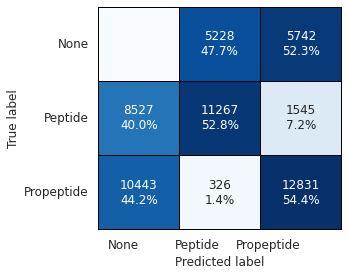

In [43]:
confusion = confusion_matrix.values
categories = confusion_matrix.index.tolist()
confusion_norm = confusion / confusion.sum(axis=1)[:, None]


group_counts = ["{0:0.0f}".format(value) for value in confusion.flatten()]
group_percentages = [
    "{0:.1%}".format(value) for value in confusion_norm.flatten()
]

# supress None-None. Cannot exist in this model.
group_percentages[0] = ''
group_counts[0] = ''

labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
labels = np.asarray(labels).reshape(len(categories), len(categories))



fig, ax = plt.subplots(1,1, figsize=(5,4))
b = sns.heatmap(
    confusion_norm,
    cmap="Blues",
    annot=labels,
    xticklabels=categories,
    yticklabels=categories,
    fmt="",
    cbar=False,
    annot_kws={"size": 12},
    linewidths=1,
    linecolor='black',
    ax=ax,
    clip_on=False,
)

ax.set_ylabel("True label", size=12)
ax.set_xlabel("Predicted label", size=12)

ax.set_yticklabels(
    ax.get_yticklabels(), rotation=0, horizontalalignment="right", fontsize=12
)

ax.set_xticklabels(
    ax.get_xticklabels(), rotation=0, horizontalalignment="right", fontsize=12
)

fig.show()
fig.tight_layout()

plt.savefig('../figures/confusion_matrix.png', dpi=1200,bbox_inches='tight')
plt.savefig('../figures/confusion_matrix.svg',bbox_inches='tight')

## PeptideLocator threshold effect

In [116]:
df = pd.read_csv('../evaluation/peptidelocator_thresholds.csv', index_col=[0,1])

In [117]:
df = df.loc[df.index.get_level_values(1)>0]
df = df.loc[df.index.get_level_values(1)<1]

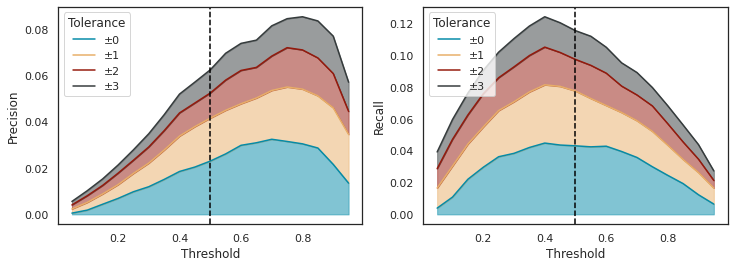

In [122]:
cmap = matplotlib.colors.ListedColormap(['#DFDBDB',  '#048BA8', '#E8AE68', '#95190C', '#353B3C'], name='from_list', N=None)


fig, axs = plt.subplots(1,2, figsize=(12,4))
ax = axs[0]
ax.plot(df.loc[0]['precision all'], label ='±0', color=cmap.colors[1])
ax.plot(df.loc[1]['precision all'], label ='±1', color=cmap.colors[2])
ax.plot(df.loc[2]['precision all'], label ='±2', color=cmap.colors[3])
ax.plot(df.loc[3]['precision all'], label ='±3', color=cmap.colors[4])
ax.legend(title='Tolerance')
ax.set_ylabel('Precision')
ax.set_xlabel('Threshold')
ax.axvline(0.5, linestyle='--', color='black')

ax.fill_between(df.loc[0]['precision all'].index, df.loc[0]['precision all'], color=cmap.colors[1], alpha=0.5)
ax.fill_between(df.loc[0]['precision all'].index, df.loc[1]['precision all'], df.loc[0]['precision all'], color=cmap.colors[2], alpha=0.5)
ax.fill_between(df.loc[0]['precision all'].index, df.loc[2]['precision all'], df.loc[1]['precision all'], color=cmap.colors[3], alpha=0.5)
ax.fill_between(df.loc[0]['precision all'].index, df.loc[3]['precision all'], df.loc[2]['precision all'], color=cmap.colors[4], alpha=0.5)


ax = axs[1]
ax.plot(df.loc[0]['recall all'], label = '±0', color=cmap.colors[1])
ax.plot(df.loc[1]['recall all'], label = '±1', color=cmap.colors[2])
ax.plot(df.loc[2]['recall all'], label = '±2', color=cmap.colors[3])
ax.plot(df.loc[3]['recall all'], label = '±3', color=cmap.colors[4])
ax.legend(title='Tolerance', loc='upper left')
ax.set_ylabel('Recall')
ax.set_xlabel('Threshold')
ax.axvline(0.5, linestyle='--', color='black')

ax.fill_between(df.loc[0]['recall all'].index, df.loc[0]['recall all'], color=cmap.colors[1], alpha=0.5)
ax.fill_between(df.loc[0]['recall all'].index, df.loc[1]['recall all'], df.loc[0]['recall all'], color=cmap.colors[2], alpha=0.5)
ax.fill_between(df.loc[0]['recall all'].index, df.loc[2]['recall all'], df.loc[1]['recall all'], color=cmap.colors[3], alpha=0.5)
ax.fill_between(df.loc[0]['recall all'].index, df.loc[3]['recall all'], df.loc[2]['recall all'], color=cmap.colors[4], alpha=0.5)

# fig.suptitle('Effect of PeptideLocator prediction threshold')

plt.savefig('../figures/peptidelocator_threshold.png', dpi=1200,bbox_inches='tight')
plt.savefig('../figures/peptidelocator_threshold.svg' ,bbox_inches='tight')